In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew


def Imagedetection(imagepath,numcards,epsilon=0.02):
    img = cv2.imread(imagepath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    # Find contours
    image,contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True) 
    # Select long perimeters only
    perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
    listindex=[i for i in range(numcards) if perimeters[i]>perimeters[0]/2]
    # Show image
    imgcont = img.copy()
    [cv2.drawContours(imgcont, [contours[i]], 0, (0,255,0), 5) for i in listindex]
   
    warp = list(range(numcards))
    
    for i in range(numcards):
        card = contours[i]
        peri = epsilon * cv2.arcLength(card,True)
        approx = cv2.approxPolyDP(card,peri,True)
        rect = cv2.minAreaRect(contours[i])
        r = cv2.boxPoints(rect)

        h = np.float32([[0,0],[399,0],[399,399],[0,399]])
        approx = np.float32([item for sublist in approx for item in sublist])
        print(approx.shape)
        transform = cv2.getPerspectiveTransform(approx,h)
        warp[i] = cv2.warpPerspective(img,transform,(400,400))

    # Show perspective correction
    
    fig = plt.figure(1, (10,10))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (4, 4), # creates 2x2 grid of axes
                    axes_pad=0.1, # pad between axes in inch.
                    aspect=True, # do not force aspect='equal'
                    )
    new_img_list = []
    for i in range(numcards):
        new_img = cv2.cvtColor(warp[i],cv2.COLOR_BGR2RGB)
        new_img_list.append(new_img)
        
        grid[i].imshow(new_img_list[i]) 
    return new_img_list


(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)
(4, 2)


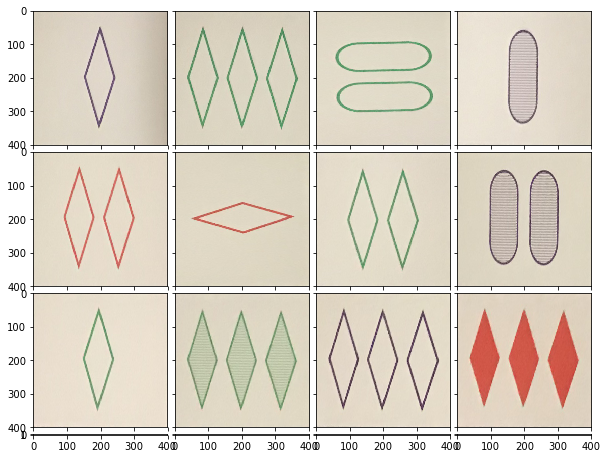

In [13]:
image_list = Imagedetection("static/images/Original/original.jpg",12)

In [14]:
def createGenerator():
    mylist = range(3)
    for i in mylist:
        yield i*i

In [15]:
mygenerator = createGenerator()

In [16]:
mygenerator

<generator object createGenerator at 0x00000193EE6C1EB8>

In [19]:
for i in mygenerator:
    print(i)

0
1
4


In [23]:
def preprocess(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)
    thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1)
    return thresh

def imgdiff(img1,img2):
    img1 = cv2.GaussianBlur(img1,(5,5),5)
    img2 = cv2.GaussianBlur(img2,(5,5),5)
    diff = cv2.absdiff(img1,img2)
    diff = cv2.GaussianBlur(diff,(5,5),5)
    flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
    return np.sum(diff)

def find_closest_card(training,img):
    features = preprocess(img)
    return sorted(training.values(), key=lambda x:imgdiff(x[1],features))[0][0]


###############################################################################
# Card Extraction
###############################################################################
def getCards(im, numcards=4):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)

    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]

    for card in contours:
        peri = cv2.arcLength(card,True)
        # print(peri)
        approx = rectify(cv2.approxPolyDP(card,0.02*peri,True))
        print(approx)

        box = np.int0(approx)
        cv2.drawContours(im,[box],0,(255,255,0),6)
        imx = cv2.resize(im,(1000,600))
        cv2.imshow('a',imx)

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h)
        warp = cv2.warpPerspective(im,transform,(450,450))

        yield warp


def get_training(training_labels_filename,training_image_filename,num_training_cards,avoid_cards=None):
    training = {}

    labels = {}
    for line in open(training_labels_filename, 'r'):
        key, num, suit = line.strip().split()
        labels[int(key)] = (num,suit)

    print ("Training")

    im = cv2.imread(training_image_filename)
    for i,c in enumerate(getCards(im,num_training_cards)):
        if avoid_cards is None or (labels[i][0] not in avoid_cards[0] and labels[i][1] not in avoid_cards[1]):
            training[i] = (labels[i], preprocess(c))

    print ("Done training")
    return training


In [17]:
labels ={}

for line in open("train.txt",'r'):
    key, num, shape,fill = line.strip().split()
    labels[int(key)] = (num,shape,name)
    
    
    print(labels[int(key)])

('1', 'O', 'E')
('2', 'D', 'E')
('3', 'D', 'E')
('3', 'D', 'E')
('3', 'D', 'E')
('1', 'D', 'E')
('2', 'O', 'E')
('3', 'D', 'E')
('1', 'D', 'E')
('2', 'O', 'E')
('2', 'D', 'E')
('1', 'D', 'E')


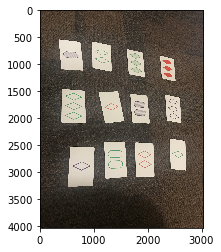

In [19]:
im = cv2.imread("train_original.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [28]:
def imgdiff(img1,img2):
    img1 = cv2.GaussianBlur(img1,(5,5),5)
    img2 = cv2.GaussianBlur(img2,(5,5),5)
    diff = cv2.absdiff(img1,img2)
    diff = cv2.GaussianBlur(diff,(5,5),5)
    flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
    return np.sum(diff)


def Imagedetection(imagepath,numcards,epsilon=0.02):
    img = cv2.imread(imagepath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    # Find contours
    image,contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True) 
    # Select long perimeters only
    perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
    listindex=[i for i in range(numcards) if perimeters[i]>perimeters[0]/2]
    # Show image
    imgcont = img.copy()
    [cv2.drawContours(imgcont, [contours[i]], 0, (0,255,0), 5) for i in listindex]
   
    warp = list(range(numcards))
    
    for i in range(numcards):
        card = contours[i]
        peri = 0.02*cv2.arcLength(card,True)
        approx =  rectify( cv2.approxPolyDP(card,peri,True))
        rect = cv2.minAreaRect(contours[i])
        r = cv2.boxPoints(rect)

        h = np.float32([[0,0],[399,0],[399,399],[0,399]])
        approx = np.float32([item for sublist in approx for item in sublist])
        print(approx.shape)
        transform = cv2.getPerspectiveTransform(approx,h)
        warp[i] = cv2.warpPerspective(img,transform,(400,400))

    # Show perspective correction
    
    fig = plt.figure(1, (10,10))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (4, 4), # creates 2x2 grid of axes
                    axes_pad=0.1, # pad between axes in inch.
                    aspect=True, # do not force aspect='equal'
                    )
    new_img_list = []
    for i in range(numcards):
        new_img = cv2.cvtColor(warp[i],cv2.COLOR_BGR2RGB)
        new_img_list.append(new_img)
        
    
    
    return new_img_list

def getCards(im, numcards=12):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY) 

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]  

    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.02*peri,True))

        # box = np.int0(approx)
        # cv2.drawContours(im,[box],0,(255,255,0),6)
        # imx = cv2.resize(im,(1000,600))
        # cv2.imshow('a',imx)      

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h)
        warp = cv2.warpPerspective(im,transform,(450,450))

        yield warp

def find_closest_card(training,img):
    features = preprocess(img)
    return sorted(training.values(), key=lambda x:imgdiff(x[1],features))[0][0]

In [30]:
im = cv2.imread("train_original.jpg")

im_list = getCards(im)

for x in im_list:
    plt.imshow(x)

ValueError: too many values to unpack (expected 2)